In [1]:
using Base.Threads
using Distributed
using CSV, DataFrames
#using DifferentialEquations
#using OrdinaryDiffEq
#using OptimizationOptimJL
#using OptimizationBBO
#using ForwardDiff
using Distributions
using Random
using Plots
using Distances

###########
global R = 8.0;
global r_nucleus = R;
 #radius of the cicle where uniform hit is generated
#Particle
#amorphous track parameters
global E = 56.0; #C 149MeV %p 80MeV %p 18.6MeV %C 280.0Mev #He 145.74-56MeV
global A = 1;
global LET = 4.5; #C 149MeV 19.56 keV/um, p 80MeV 0.86(0.6) keV/um, p 18.6MeV  2.76 keV/um %C 280.0Mev 13.12 keV/um #He 145.74-56MeV 4.5
global rho = 1;

par = string("He", "_", string(E));

#Time and number of particle
global Dose = 1.0;
global kR = 0.8;

@everywhere function ATRadius(E, A, kR)

    Rc = 0.01;

    Rp = 0.05*((E/A)^(1.7));

    if kR < 1.0
        Rk = Rc*exp((kR*(1+2*log(Rp/Rc))-1)/2);
    else
        Rk = Rp;
    end

    return Rc, Rp, Rk

end

global (Rc, Rp, Rk) = ATRadius(E, A, kR);
println("Rc=",Rc,"\nRp=",Rp,"\nRk=",Rk)

global DoseRate = 0.18; #10
global DoseRate_h = DoseRate*3600;

global F = Dose/(1.602*10^(-9)*LET);
global Npar = round(Int, F*(pi*(R+Rk)^2*10^(-8)));
# if no simulation of time
#Np = round(Int, Dose/(1.602*10^(-9)*LET/(pi*(R+Rk)^2*10^(-8))));
#Np = Npar;

#zF = 1.602*10^(-9)*LET/(pi*(R+Rk)^2*10^(-8));
global zF = Dose/Npar;
global D = DoseRate_h/zF;
global T = Dose/(zF*D)*3600;
#######################
@everywhere function GenerateHit(R, Rk)

    radius = (R+Rk)*sqrt((rand(Uniform(0,1))));
    theta = 2*pi*rand(Uniform(0,1));

    x0 = radius*cos(theta);
    y0 = radius*sin(theta);

    return x0, y0

end
#######################
@everywhere function GetRadialLinearDose(r)
    #LET normalized to Rk ???
    LETk = LET*0.1602;####JM: why thi is usefull?
    D_arc=0.
    if r <= Rc
        D_arc = (1/(pi*Rc^2))*(LETk/(1*(1+2*log(Rk/Rc))));
    elseif r <= Rk
        D_arc = (1/(pi*r*r))*(LETk/(1*(1+2*log(Rk/Rc))));
    end
    return D_arc
end

##############
function arc_intersection_angle(r, b, r_nucleus)
    if b < r_nucleus
        if r <= r_nucleus - b
            return 2 * π
        elseif r < b + r_nucleus
            arg = b/(2*r)  + r/(2*b)  - r_nucleus * r_nucleus / (2 * b * r)
            arg = min(arg, 1.0) #not sure if usefull?
            arg = max(arg, -1.0)
            return 2 * acos(arg)
        end
    else #(b>=r_nucleus)
        if r <= b - r_nucleus
            return 0.0
        elseif r < b + r_nucleus
            arg =b/(2*r)  + r/(2*b)  - r_nucleus * r_nucleus / (2 * b * r)
            arg = min(arg, 1.0) #not sure if usefull?
            arg = max(arg, -1.0)
            return 2 * acos(arg)
        end
    end
    return 0.0
end
##############
function integrate_weighted_radial_track( rMin::Float64, rMax::Float64, b::Float64, r_nucleus::Float64, step::Int64)
    r1, r2, log_r2, log_rMin, log_rMax, log_step = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    f1, f2, f, arc_weight1, arc_weight2 = 0.0, 0.0, 0.0, 0.0, 0.0
    integral = 0.0
    if rMin > 0
        log_rMin = log10(rMin)
    else
        log_rMin = -5.
    end
    log_rMax = log10(rMax)
    nSteps = step
    log_step = (log_rMax - log_rMin) / nSteps
    #println(log_step)
    if nSteps < 3
        log_step = (log_rMax - log_rMin) / 3
        nSteps = 3
    end
    area = 0.0
    arc_weight2 = arc_intersection_angle(rMin, b, r_nucleus)
    f2 = GetRadialLinearDose(rMin) * rMin * arc_weight2
    r2 = rMin
    for i in 1:nSteps - 1
        log_r2 = log_rMin + log_step * (i + 1)
        f1 = f2
        r1 = r2
        arc_weight1 = arc_weight2
        #println(r2 ,"\n")
        r2 = 10^log_r2
        arc_weight2 = arc_intersection_angle(r2, b, r_nucleus)
        f2 = GetRadialLinearDose(r2) * r2 * arc_weight2
        f = (r2 - r1) * (f1 / 2.0 + f2 / 2.0)
        integral += f
        area += (r2 - r1) * (arc_weight1 * r1 / 2.0 + arc_weight2 * r2 / 2.0)
    end
    ####Pass 1<-2
    f1 = f2
    r1 = r2
    arc_weight1 = arc_weight2
    #### Fill 2
    r2 = rMax
    arc_weight2 = arc_intersection_angle(r2, b, r_nucleus)
    f2 = GetRadialLinearDose(r2) * r2 * arc_weight2
    f = (r2 - r1) * (f1 / 2.0 + f2 / 2.0)
    integral += f
    area += (r2 - r1) * (arc_weight1 * r1 / 2.0 + arc_weight2 * r2 / 2.0)
    return area, integral, integral/area
end

#####################################
struct Cell
    x::Float64
    y::Float64
    r::Float64
end

struct Track
    x::Float64
    y::Float64
    Rk::Float64
end


function distribute_dose(cell::Cell, track::Track)
    x_track, y_track = track.x,track.y
    x_track = (x_track - cell.x) #* 1e3  # mm -> um ??
    y_track = (y_track - cell.y) #* 1e3  # mm -> um
    b = sqrt(x_track^2 + y_track^2)

    rMax = min(Rk, b + cell.r)

    area1 = area2 = area3 = 0.0

    if b <= cell.r
        #nucleus.inNucleusCount += 1
        rMin = 0.0

        if b + track.Rk < cell.r
            r_intersection = track.Rk
        else
            r_intersection = cell.r - b
        end

        area1 = π * r_intersection^2
        area,integral,Gyr=integrate_weighted_radial_track(0., r_intersection, b, cell.r,1000);
        dose=integral
        # dose = track.getRadialIntegral(0.0, r_intersection) * area1

        if rMax > r_intersection
            area,integral,Gyr=integrate_weighted_radial_track(r_intersection, rMax, b, cell.r,1000);
            area2 = area #track, r_intersection, rMax, b, 0.01
            dose += integral
        end

        if rMax == track.Rk
            if track.Rk > cell.r - b
               theta1 = acos((b/(2*rMax) + rMax/(2*b) - (cell.r^2) / (2 * b * rMax)))
               theta2 = acos((b/(2*cell.r) - (rMax*rMax)/(2*b*cell.r) + (cell.r) / (2 * b)))
               area3 = π * cell.r^2 - (theta1 * track.Rk^2 + theta2 * cell.r^2 - track.Rk * b * sin(theta1))
            else
                area3 = π * (cell.r^2 - r_intersection^2)
            end
        end

        #dose /= area1 + area2 + area3
        Gyr=dose/(area1+area2+ area3)
       # println("area1: ",area1," area2: ",area2," area3: ",area3,"\n1 sumareas:",area1+area2+area3," aera cell:",cell.r*cell.r*π, "\n",area1+area2+area3-cell.r*cell.r*π)

        #nucleus.totalNucleusDose += dose
       # push!(nucleus.doses, dose)
        #push!(nucleus.times, track.getTime())

    elseif b <= cell.r + track.Rk
        #nucleus.intersectionCount += 1
        rMin = b - cell.r
        area,integral,Gyr = integrate_weighted_radial_track(rMin, rMax, b, cell.r,1000)
        dose = integral
        area2=area
        if rMax == track.Rk
            theta1 = acos((b/(2*rMax) + rMax/(2*b) - (cell.r^2) / (2 * b * rMax)))
            theta2 = acos((b/(2*cell.r) - (rMax*rMax)/(2*b*cell.r) + (cell.r) / (2 * b)))
            area3 = π * cell.r^2 - (theta1 * track.Rk^2 + theta2 * cell.r^2 - track.Rk * b * sin(theta1))
        end

        Gyr = dose/(area2 + area3)

        #nucleus.totalNucleusDose += dose
        #return dose, area1+area2+area3, Gyr
       # push!(cell.doses, dose)
        #push!(nucleus.times, track.getTime())
    end
    return dose, area1+area2+area3, Gyr
end



#####################################
struct Cell
    x::Float64
    y::Float64
    r::Float64
end

struct Track
    x::Float64
    y::Float64
    Rk::Float64
end


##############

@everywhere function integrate_weighted_radial_track_vector( rMin::Float64, rMax::Float64, b::Float64, r_nucleus::Float64, nSteps::Int64)
    r1, r2, log_r2, log_rMin, log_rMax, log_step = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    f1, f2, f, arc_weight1, arc_weight2 = 0.0, 0.0, 0.0, 0.0, 0.0
    local integral = Array{Float64}(undef,0)
    local theta = Array{Float64}(undef,0)
    local radius = Array{Float64}(undef,0)
    if rMin > 0
        log_rMin = log10(rMin)
    else
        log_rMin = -5.
    end
    log_rMax = log10(rMax)
    #nSteps = step
    log_step = (log_rMax - log_rMin) / nSteps
    #println(log_step)
    if nSteps < 3
        log_step = (log_rMax - log_rMin) / 3
        nSteps = 3
    end
    area = 0.0
    arc_weight2 = arc_intersection_angle(rMin, b, r_nucleus)
    #push!(theta,arc_weight2/2)
    f2 = GetRadialLinearDose(rMin) * rMin * arc_weight2
    r2 = rMin
    for i in 1:nSteps - 1
        log_r2 = log_rMin + log_step * (i + 1)
        f1 = f2
        r1 = r2
        arc_weight1 = arc_weight2
        #println(r2 ,"\n")
        r2 = 10^log_r2
        arc_weight2 = arc_intersection_angle(r2, b, r_nucleus)
        push!(theta, arc_weight1)
        f2 = GetRadialLinearDose(r2) * r2 * arc_weight2
        f = (r2 - r1) * (f1 / 2.0 + f2 / 2.0)
        push!(integral,f)
        area += (r2 - r1) * (arc_weight1 * r1 / 2.0 + arc_weight2 * r2 / 2.0)
        push!(radius,r1)
    end
    ####Pass 1<-2
    f1 = f2
    r1 = r2
    arc_weight1 = arc_weight2
    #### Fill 2
    r2 = rMax
    arc_weight2= arc_intersection_angle(r2, b, r_nucleus)
    push!(theta, arc_weight1)
    push!(theta, arc_weight2)
    f2 = GetRadialLinearDose(r2) * r2 * arc_weight2
    f = (r2 - r1) * (f1 / 2.0 + f2 / 2.0)
    push!(integral,f)
    area += (r2 - r1) * (arc_weight1 * r1 / 2.0 + arc_weight2 * r2 / 2.0)
    push!(radius,r1)
    push!(radius,r2)
    return integral, theta, area, radius
end

#####################################


@everywhere function distribute_dose_vector(cell::Cell, track::Track)
    x_track, y_track = track.x,track.y
    x_track = (x_track - cell.x) #* 1e3  # mm -> um ??
    y_track = (y_track - cell.y) #* 1e3  # mm -> um
    b = sqrt(x_track^2 + y_track^2)

    rMax = min(Rk, b + cell.r)

    area1 = area2 = area3 = 0.0

    if b <= cell.r
        #nucleus.inNucleusCount += 1
        rMin = 0.0

        if b + track.Rk < cell.r
            r_intersection = track.Rk
        else
            r_intersection = cell.r - b
        end

        area1 = π * r_intersection^2
        integral1, theta11, area1, radius1 = integrate_weighted_radial_track_vector(0., r_intersection, b, cell.r, 1000);
        dose = sum(integral1)
        # dose = track.getRadialIntegral(0.0, r_intersection) * area1

        if rMax > r_intersection
            integral2, theta21, area, radius2 = integrate_weighted_radial_track_vector(r_intersection, rMax, b, cell.r,1000);
            area2 = area #track, r_intersection, rMax, b, 0.01
            dose += sum(integral2)
            integral = [integral1; integral2];
            theta = [theta11; theta21];
            radius = [radius1; radius2];
        else
            integral = integral1;
            theta = theta11;
            radius = radius1;
        end

        if rMax == track.Rk
            if track.Rk > cell.r - b
               theta1 = acos((b/(2*rMax) + rMax/(2*b) - (cell.r^2) / (2 * b * rMax)))
               theta2 = acos((b/(2*cell.r) - (rMax*rMax)/(2*b*cell.r) + (cell.r) / (2 * b)))
               area3 = π * cell.r^2 - (theta1 * track.Rk^2 + theta2 * cell.r^2 - track.Rk * b * sin(theta1))
            else
                area3 = π * (cell.r^2 - r_intersection^2)
            end
        end

        #dose /= area1 + area2 + area3
        Gyr=dose/(area1+area2+ area3)
       # println("area1: ",area1," area2: ",area2," area3: ",area3,"\n1 sumareas:",area1+area2+area3," aera cell:",cell.r*cell.r*π, "\n",area1+area2+area3-cell.r*cell.r*π)

        #nucleus.totalNucleusDose += dose
       # push!(nucleus.doses, dose)
        #push!(nucleus.times, track.getTime())

    elseif b <= cell.r + track.Rk
        #nucleus.intersectionCount += 1
        rMin = b - cell.r
        integral, theta, area, radius = integrate_weighted_radial_track_vector(rMin, rMax, b, cell.r, 1000)
        dose = sum(integral)
        area2=area
        if rMax == track.Rk
            theta1 = acos((b/(2*rMax) + rMax/(2*b) - (cell.r^2) / (2 * b * rMax)))
            theta2 = acos((b/(2*cell.r) - (rMax*rMax)/(2*b*cell.r) + (cell.r) / (2 * b)))
            area3 = π * cell.r^2 - (theta1 * track.Rk^2 + theta2 * cell.r^2 - track.Rk * b * sin(theta1))
        end

        Gyr = dose/(area2 + area3)

        #nucleus.totalNucleusDose += dose
        #return dose, area1+area2+area3, Gyr
       # push!(cell.doses, dose)
        #push!(nucleus.times, track.getTime())
    end
    return integral, theta, Gyr, radius
end


cell=Cell(0.,0., R)
x,y= GenerateHit(R,Rk);
track=Track(x,y,Rk);
#dose, area, Gyr= distribute_dose(cell,track)
#global Np=rand(Poisson(Npar))

#function to calculate the average yield of damage per unit Gy
@everywhere function calculate_kappa(ion,LET)

    if ion == "12C"
        p1 = 6.8;
        p2 = 0.156;
        p3 = 0.9214;
        p4 = 0.005245;
        p5 = 1.395;
    elseif ion == "4He"
        p1 = 6.8;
        p2 = 0.1471;
        p3 = 1.038;
        p4 = 0.006239;
        p5 = 1.582;
    elseif ion == "3He"
        p1 = 6.8;
        p2 = 0.1471;
        p3 = 1.038;
        p4 = 0.006239;
        p5 = 1.582;
    elseif ion == "1H"
        p1 = 6.8;
        p2 = 0.1773;
        p3 = 0.9314;
        p4 = 0;
        p5 = 1;
    elseif ion == "2H"
        p1 = 6.8;
        p2 = 0.1773;
        p3 = 0.9314;
        p4 = 0;
        p5 = 1;
    elseif ion == "16O"
        p1 = 6.8;
        p2 = 0.1749;
        p3 = 0.8722;
        p4 = 0.004987;
        p5 = 1.347;
    end
    yield = (p1 + (p2*LET)^p3)/(1+ (p4*LET)^p5);

    return yield
end

#function to calculate the spatial position of the damages
#for each track calculate the dose on the cell and ditribute the damages around the cell nucleus

@everywhere function calculate_damage(ion, LET, integral, theta, Gyr)
    
    X = Array{Float64}(undef, 0, Nd);
    Y = Array{Float64}(undef, 0, Nd);

    theta_ = [theta[1:end-1]./2 theta[2:end]./2]
    theta = minimum(theta_, dims = 2)

    b = sqrt(x*x + y*y)
    
    kappa_DSB = 9*calculate_kappa(ion,LET);
    lambda_DSB = kappa_DSB*10^-3;

    x0d = rand(Poisson(kappa_DSB*Gyr))
    y0d = rand(Poisson(lambda_DSB*Gyr))

    if (x0d == 0) & (y0d == 0)
        return X, Y
    end

    if x0d > 0
        radius_xP = rand(Categorical((integral/sum(integral))), x0d)
        radius_x = (radius[radius_xP .+ 1] - radius[radius_xP]).*rand(Uniform(0,1),x0d) .+ radius[radius_xP];
        if (x >= 0)
            theta_x = 3*π/2 .- acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),x0d).*[-1 ,1][rand(Bernoulli(),x0d) .+ 1];
        elseif (x < 0)
            theta_x = 3*π/2 .+ acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),x0d).*[-1 ,1][rand(Bernoulli(),x0d) .+ 1];
        end
        Xx = radius_x.*cos.(theta_x) .+ x;
        Xy = radius_x.*sin.(theta_x) .+ y;
        for i in 1:x0d
            X = vcat(X,reshape([Xx[i], Xy[i], R*rand(Uniform(0,1),1)[1]], 1, :));
        end
    end
    if y0d > 0
        radius_yP = rand(Categorical((integral/sum(integral))), y0d)
        radius_y = (radius[radius_yP .+ 1] - radius[radius_yP]).*rand(Uniform(0,1),y0d) .+ radius[radius_yP];
        if (x >= 0) 
            theta_y = 3*π/2 .- acos.(y/b) .+ theta[radius_yP].*rand(Uniform(0,1),y0d).*[-1 ,1][rand(Bernoulli(),y0d) .+ 1];
        elseif (x < 0) 
            theta_y = 3*π/2 .+ acos.(y/b) .+ theta[radius_yP].*rand(Uniform(0,1),y0d).*[-1 ,1][rand(Bernoulli(),y0d) .+ 1];  
        end
        Yx = radius_y.*cos.(theta_y) .+ x;
        Yy = radius_y.*sin.(theta_y) .+ y;
        for i in 1:x0d
            Y = vcat(Y,reshape([Yx[i], Yy[i], R*rand(Uniform(0,1),1)[1]], 1, :));
        end
    end

    return X, Y
end

########################
#Simulation dose
#Nd is the dimension fo the space, cell is assumed to be a cylinder. The geometry can be more complicated but for now it is fine
Nd = 3;
#X and Y are matrices with the cartesian coordinates of the damages
X = Array{Float64}(undef, 0, Nd);
Y = Array{Float64}(undef, 0, Nd);

# check the code for a single track
begin
x,y= GenerateHit(R,Rk)
x = 7.098
y = -7.662
track=Track(x,y,Rk)
integral, theta, Gyr, radius = distribute_dose_vector(cell,track);
#theta /= 2;
theta_ = [theta[1:end-1]./2 theta[2:end]./2]
theta = minimum(theta_, dims = 2)

b = sqrt(x*x + y*y)
integral[integral .< 0] .= 0;
Nd = 3;
ion = "4He";
kappa_DSB = 9*calculate_kappa(ion,LET);
lambda_DSB = kappa_DSB*10^-3;

x0d = rand(Poisson(kappa_DSB*Gyr))
y0d = rand(Poisson(lambda_DSB*Gyr))

x0d = 10

if x0d > 0
    radius_xP = rand(Categorical((integral/sum(integral))), x0d)
    radius_x = (radius[radius_xP .+ 1] - radius[radius_xP]).*rand(Uniform(0,1),x0d) .+ radius[radius_xP];
    if (x >= 0) & (y >= 0)
        theta_x = 3*π/2 .- acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),x0d).*[-1 ,1][rand(Bernoulli(),x0d) .+ 1];
    elseif (x > 0) & (y < 0)
        theta_x = 3*π/2 .- acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),x0d).*[-1 ,1][rand(Bernoulli(),x0d) .+ 1];
    elseif (x < 0) & (y > 0)
        theta_x = 3*π/2 .+ acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),x0d).*[-1 ,1][rand(Bernoulli(),x0d) .+ 1];
    elseif (x < 0) & (y < 0)
        theta_x = 3*π/2 .+ acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),x0d).*[-1 ,1][rand(Bernoulli(),x0d) .+ 1];
    end
    Xx = radius_x.*cos.(theta_x) .+ x;
    Xy = radius_x.*sin.(theta_x) .+ y;
    for i in 1:x0d
       global X = vcat(X,reshape([Xx[i], Xy[i], R*rand(Uniform(0,1),1)[1]], 1, :));
    end
end
if y0d > 0
    radius_yP = rand(Categorical((integral/sum(integral))), y0d)
    radius_y = (radius[radius_yP .+ 1] - radius[radius_yP]).*rand(Uniform(0,1),y0d) .+ radius[radius_yP];
    if (x >= 0) & (y >= 0)
        theta_y = 3*π/2 .- acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),y0d).*[-1 ,1][rand(Bernoulli(),y0d) .+ 1];
    elseif (x > 0) & (y < 0)
        theta_y = 3*π/2 .- acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),y0d).*[-1 ,1][rand(Bernoulli(),y0d) .+ 1];
    elseif (x < 0) & (y > 0)
        theta_y = 3*π/2 .+ acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),y0d).*[-1 ,1][rand(Bernoulli(),y0d) .+ 1];  
    elseif (x < 0) & (y < 0)
        theta_y = 3*π/2 .+ acos.(y/b) .+ theta[radius_xP].*rand(Uniform(0,1),y0d).*[-1 ,1][rand(Bernoulli(),y0d) .+ 1];
    end
    Yx = radius_y.*cos.(theta_y) .+ x;
    Yy = radius_y.*sin.(theta_y) .+ y;
    for i in 1:x0d
        global Y = vcat(Y,reshape([Yx[i], Yy[i], R*rand(Uniform(0,1),1)[1]], 1, :));
    end
end


integral[integral .< 0] .= 0;
Nd = 3;
ion = "4He";
theta_ = [theta[1:end-1]./2 theta[2:end]./2]
theta = minimum(theta_, dims = 2)
X_, Y_ = calculate_damage(ion, LET, integral, theta, Gyr)

X = vcat(X,X_)
end



#run code to simulate the spatial distribution of the damage for all the tracks
#the function calculate_damage is not optimized but for the moment is only slighlty slower than the code that calculates the dose 
#e.g. the dose deposited by 1046 tracks is computed in 0.56 seconds
#the dose deposited by 1109 tracks and the corresponding spatial distribution of the damages is computed in 0.62 seconds
@time begin
    Np=rand(Poisson(Npar))
    cell=Cell(0.,0., R)
    local DOSE_tot = 0. ;
    local GYR_tot  = 0. ;
    #println(Np)
    for i in 1:Np
        local x,y= GenerateHit(R,Rk);
        local track=Track(x,y,Rk);
        local dose, area, Gyr = distribute_dose(cell,track);
        DOSE_tot+=dose
        GYR_tot+=Gyr
    end
    #println(DOSE_tot)
    #println(GYR_tot)
end


R = 8.0; #radius of the cicle where uniform hit is generated
#Particle
#amorphous track parameters
E = 56.0; #C 149MeV %p 80MeV %p 18.6MeV %C 280.0Mev #He 145.74-56MeV
A = 1;
LET = 4.5; #C 149MeV 19.56 keV/um, p 80MeV 0.86(0.6) keV/um, p 18.6MeV  2.76 keV/um %C 280.0Mev 13.12 keV/um #He 145.74-56MeV 4.5
rho = 1;

par = string("He", "_", string(E));

#Time and number of particle
Dose = 1.0;
kR = 0.8;

(Rc, Rp, Rk) = ATRadius(E, A, kR);
println("Rc=",Rc,"\nRp=",Rp,"\nRk=",Rk)

DoseRate = 0.18; #10
DoseRate_h = DoseRate*3600;

F = Dose/(1.602*10^(-9)*LET);
Npar = round(Int, F*(pi*(R+Rk)^2*10^(-8)));
# if no simulation of time
#Np = round(Int, Dose/(1.602*10^(-9)*LET/(pi*(R+Rk)^2*10^(-8))));
#Np = Npar;

#zF = 1.602*10^(-9)*LET/(pi*(R+Rk)^2*10^(-8));
zF = Dose/Npar;
D = DoseRate_h/zF;
T = Dose/(zF*D)*3600;

@time begin
    Np=rand(Poisson(Npar))
    cell=Cell(0.,0., R)
    local DOSE_tot = 0. ;
    local GYR_tot  = 0. ;
    println(Np)
    local X = Array{Float64}(undef, 0, Nd);
    local Y = Array{Float64}(undef, 0, Nd);
    for i in 1:Np
        #println(i)
        local x,y= GenerateHit(R,Rk)
        local track=Track(x,y,Rk)
        local integral, theta, Gyr, radius = distribute_dose_vector(cell,track);
        integral[integral .< 0] .= 0;
        local Nd = 3;
        local ion = "4He";
        local theta_ = [theta[1:end-1]./2 theta[2:end]./2]
        theta = minimum(theta_, dims = 2)
        local X_, Y_ = calculate_damage(ion, LET, integral, theta, Gyr);

        dist =sqrt.(X_[:,1].*X_[:,1] .+ X_[:,2].*X_[:,2])
        if size(dist[dist .> 8],1) != 0
            return x,y 
        end

        X = vcat(X,X_)
        Y = vcat(Y,Y_)
        #DOSE_tot+=dose
        GYR_tot+=Gyr
    end
    #println(DOSE_tot)
    println(GYR_tot)
end

dist =sqrt.(X[:,1].*X[:,1] .+ X[:,2].*X[:,2])
dist[dist .> 8]

#check if some damages are being (wrongly) created outside the cell
err = findall(x -> x >= 8, dist)
# Define the outcomes and their corresponding probabilities
X[err,:]

using PlotlyJS


#plot the spatial distribution of damages

df = DataFrame(X,:auto)

plt=Plot(
    df,
    x=:x1, y=:x2, z=:x3,
    type="scatter3d", mode="markers"
)
display(plt)


Rc=0.01
Rp=46.86942766272948
Rk=7.821359928664614
  0.974909 seconds (29.97 M allocations: 457.561 MiB, 0.96% gc time, 0.48% compilation time)
Rc=0.01
Rp=46.86942766272948
Rk=7.821359928664614
1100


WebIO._IJuliaInit()

data: [
  "scatter3d with fields mode, type, x, xaxis, y, yaxis, and z"
]

layout: "layout with fields legend, margin, template, xaxis, and yaxis"

In [2]:
using WebIO,PlotlyJS
#plotlyjs()
function CylinderShape(x,y,r,h)# (the cell)
    r_cyl = r
    h_cyl  = h
    m_cyl , n_cyl  =100, 100
    u  = range(0, 2pi, length=n_cyl )
    v = range(0, h_cyl, length=m_cyl )
    us = ones(m_cyl)*u'
    vs = v*ones(n_cyl)'
    #Surface parameterization
    X  = r_cyl*cos.(us).+x
    Y  = r_cyl*sin.(us).+y
    Z  = vs
    return X,Y,Z
end

CylinderShape (generic function with 1 method)

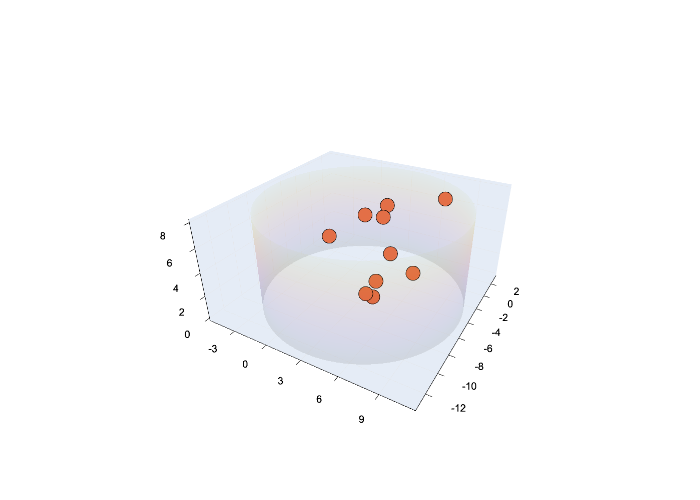

In [4]:
using Plots
plotlyjs()
X_cyl,Y_cyl,Z_cyl=CylinderShape(3,-5,8.,8.) 
plt1=Plots.surface(
    X_cyl, Y_cyl, Z_cyl, 
    size=(600,600),
    opacity=0.3, 
    cbar=:none, 
    legend=false)
Plots.scatter!(
    df.x1,df.x2,df.x3,
    mode="markers"
)

display(plt1)

In [ ]:
#Run the spatial model (I think it can be  savoided but it not slow anyway)
#return 0 if dead, 1 if Survivial_reala

a = 0.01; b = 0.01; r = 4;
rd = 1;

@everywhere function spatial_GSM2(X,Y,a,b,r,rd)
    while size(X)[1] != 0
    
        init_size = size(X)[1];

        Tr = [0,0,0];
        Rr = [rand(Uniform(0,1)), rand(Uniform(0,1)), rand(Uniform(0,1))];
        Sr = log.(1 ./ Rr);
        time_all = Array{Float64}(undef, 0);
        time = 0.0;

        aX = a*size(X)[1];
        dist = pairwise(Euclidean(), transpose(X));
        dist[dist .> rd] .= 0;
        bXM = b.*dist;
        bX = sum(bXM)/2;
        rX = r*size(X)[1];

        tau = (Sr .- Tr)./[rX, aX, bX];
        taus = minimum(tau);

        Tr += taus.*[rX, aX, bX];
        time += taus;
        append!(time_all,time);

        if argmin(tau) == 1
            #println("r")

            X = X[1:end .!= rand(DiscreteUniform(1,size(X)[1])), :];
        elseif argmin(tau) == 2
            #println("a")

            rem = rand(DiscreteUniform(1,size(X)[1]));
            Y = vcat(Y,reshape(X[rem,:], 1, :));
            X = X[1:end .!= rem, :];

        elseif argmin(tau) == 3
            #println("b")

            prob_matrix = bXM./sum(bXM);
            selected_index = rand(Categorical(vec(prob_matrix)), 1)[1];
            row = (selected_index ÷ size(bXM)[1]) + 1;
            cols = ifelse(selected_index % size(bXM)[1] == 0, size(bXM)[1], selected_index % size(bXM)[1]);

            Y = vcat(Y,reshape((X[cols,:]+X[row,:])/2, 1, :));
            X = X[setdiff(1:end, (cols, row)), :];
        end
        Sr .+= log.(1/rand(Uniform(0,1)));


        if init_size == size(X)[1]
            println("Error")
            return -1
        end
        if size(Y)[1] > 0
            #println("Dead")
            return 0
        end
    end

    return 1
end

#Given the previously computed X and Y calculate if the cell survives or not
#1.4 seconds, but I think I can compute the surviving probability analytically
@time begin
    surv = spatial_GSM2(X,Y,a,b,r,rd)
end


X_old = X;
Y_old = Y;

surv = Array{Float64}(undef, 0);
for s in 1:10^4 
    #println(s)
    X = X_old;
    Y = Y_old;
    push!(surv,spatial_GSM2(X,Y,a,b,r,rd))
end

surv_prob = size(surv[surv.>0])[1]/10^4

@time begin
    Np=rand(Poisson(Npar))
    cell=Cell(0.,0., R)
    local DOSE_tot = 0. ;
    local GYR_tot  = 0. ;
    println(Np)
    local X = Array{Float64}(undef, 0, Nd);
    local Y = Array{Float64}(undef, 0, Nd);
    for i in 1:Np
        #println(i)
        local x,y= GenerateHit(R,Rk)
        local track=Track(x,y,Rk)
        local integral, theta, Gyr, radius = distribute_dose_vector(cell,track);
        integral[integral .< 0] .= 0;
        local Nd = 3;
        local ion = "4He";
        local theta_ = [theta[1:end-1]./2 theta[2:end]./2]
        local theta = minimum(theta_, dims = 2)
        local X_, Y_ = calculate_damage(ion, LET, integral, theta, Gyr);

        local dist =sqrt.(X_[:,1].*X_[:,1] .+ X_[:,2].*X_[:,2])
        if size(dist[dist .> 8],1) != 0
            return x,y 
        end

        X = vcat(X,X_)
        Y = vcat(Y,Y_)
        #DOSE_tot+=dose
        GYR_tot+=Gyr
    end
    println(DOSE_tot)
    println(GYR_tot)
end


@everywhere function spatial_GSM2_fast(X,Y,a,b,r,rd)
    
    dist = pairwise(Euclidean(), transpose(X));
    dist[dist .> rd] .= 0;
    p = 1;
    if size(Y)[1] > 0
        return 0
    else
        for i in 1:size(X)[1]
            p *= r/(r+a+b*sum(dist[i,:]))
        end
    end

    return p
end

X = X_old;
Y = Y_old;

@time begin
    survP = spatial_GSM2_fast(X,Y,a,b,r,rd)
end


In [ ]:
using Plots,WebIO,PlotlyJS,Distributions
plotlyjs()
function SphereShape(x,y,z,r)# (the cell)
    N = 100
    u = range(0, stop=2π, length=N)
    v = range(0, stop=π, length=N)
    X = r.*cos.(u) .* sin.(v)'.+x
    Y = r.*sin.(u) .* sin.(v)'.+y
    Z = repeat(r.*cos.(v)',outer=[N, 1]).+z
   
    return X,Y,Z
end
mutable struct Cell3D
    x::Float64
    y::Float64
    z::Float64
    r::Float64
end
function GenerateCells(r_min,r_max,R_tumor)
    radius = (R_tumor-r_max)*sqrt((rand(Uniform(0,1))));
    theta = 2*π*rand(Uniform(0,1));
    phi=π*rand(Uniform(0,1))
    X = radius.*cos.(theta) .* sin.(phi)'
    Y = radius.*sin.(theta) .* sin.(phi)'
    Z = radius.*cos.(phi)'
    R=r_min+rand(Uniform(0,1))*(r_max-r_min)
    return Cell3D(X,Y,Z,R)
end   

X,Y,Z=SphereShape(0,0,0,30.)
plt1=Plots.surface(
    X, Y, Z, 
    size=(600,600),
    opacity=0.3, 
    cbar=:none, 
    legend=false)
N = 10 
# create an uninitialized 1D array of size N
arrayOfCells = Array{Cell3D, 1}(undef, N) 
println(arrayOfCells)
function checkCollisions(arrayOfCells,I,cell::Cell3D)
    YN=false
        for i in 1:I
            if isdefined(arrayOfCells, i) == true
                local x,y,z,r=arrayOfCells[i]
                local dist=((x-cell.x)^2+(y-cell.y)^2+(z-cell.z)^2)^(1/2)
                if dist<(r+cell.r)
                        YN=true
                break
                else
                        YN=false
                end
            else
                YN=false
                break
            end
        end
    return YN
end
for i = 1:N
    cell=GenerateCells(7.5,8.5,30.)
    if checkCollisions(arrayOfCells,i,cell) == false
        arrayOfCells[i] = cell
    else
        println("rejected")
    end
end

for i in 1:length(arrayOfCells)
    x,y,z,r=arrayOfCells[i].x,arrayOfCells[i].y,arrayOfCells[i].z,arrayOfCells[i].r
    X,Y,Z=SphereShape(x,y,z,r)
    Plots.surface!(
    X, Y, Z, 
    size=(600,600),
    opacity=1, 
    color=cgrad(:matter, N, categorical = true)[i], 
    legend=false)
    
end

In [ ]:
plt1

In [12]:
using CALiPPSO
precompile_main_function() #optional, but highly recommended. This will produce a colorful output that you can safely ignore
using Random
Random.seed!(123) # optional, but just for reproducibility sake of this MWE
# Choosing the seed of the Julia's RNG determines the random IC produces below with `generate_random_configuration`

dim, Ncell, φ0, L = 3, 16, 0.3, 1.0
R, Xs = generate_random_configuration(dim, Ncell, φ0, L) # if L is not passed, it's assumed that the systems is in a box of size 1

